# Image Exploration for VIS-IR Dataset

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import jupyter_compare_view
import imutils

from matplotlib.widgets import RangeSlider

## Load and process data

In [2]:
# Feel free to edit as you like depending on where you put the files
BASE_IMAGE_DIR = "VIS_IR_DATASET"
FILE_NAME = "2021-11-15_22-52-14.jpg"

In [3]:
im = cv2.imread(f"{BASE_IMAGE_DIR}/{FILE_NAME}")

In [14]:
# The default image shape is represented as (height, width, channels)
print(im.shape)

(2464, 6560, 3)


In [5]:
# The image contains the VIS and IR Image side by side
assert im.shape[1] % 2 == 0
im_vis = im[:, :(im.shape[1]//2), :]
im_ir = im[:, (im.shape[1]//2):, :]

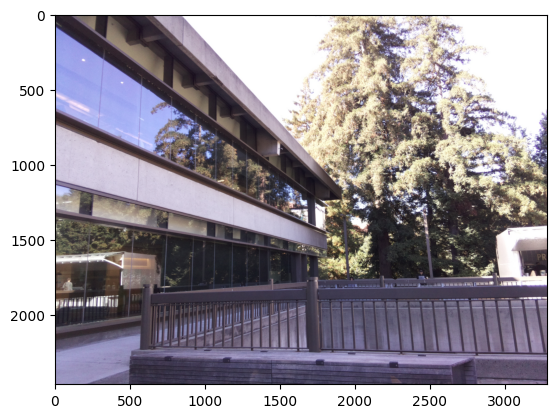

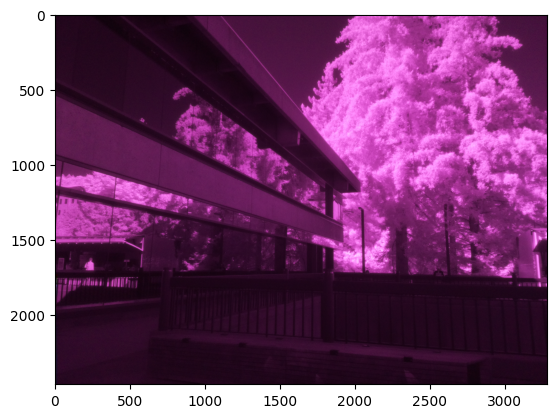

In [15]:
# Display the images for reference, all images must use cv2.cvtColor as cv2 stores images as BGR instead of RGB
plt.imshow(cv2.cvtColor(im_vis, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(im_ir, cv2.COLOR_BGR2RGB))
plt.show()

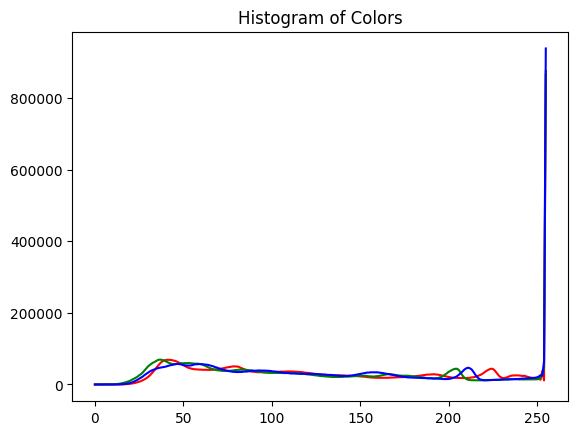

In [7]:
# Plot of a histogram of colors to see how they look. It is clear that the images are overexposed 
plt.title(f"Histogram of Colors")
channel_names = ["red", "green", "blue"]
for channel in range(3):
    hist = cv2.calcHist([im_vis], [channel], None, [256], [0, 256])
    plt.plot(hist, color=channel_names[channel]) 
plt.show()

In [8]:
# Align images code was taken from https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/
# tl;dr align images finds features within an image and an template and attempts to match them using the
# RANSAC algorithm then computes a homography matrix to align the image.

def align_images(image, template, maxFeatures=5000, keepPercent=0.1,
    debug=False):
    # convert both the input image and template to grayscale
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    # use ORB to detect keypoints and extract (binary) local
    # invariant features
    orb = cv2.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)
    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)
    
    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x:x.distance)
    # keep only the top matches
    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]
    # check to see if we should visualize the matched keypoints
    if debug:
        matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,
            matches, None)
        matchedVis = imutils.resize(matchedVis, width=1000)
        cv2.imshow("Matched Keypoints", matchedVis)
        cv2.waitKey(0)
        
    # allocate memory for the keypoints (x, y)-coordinates from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for (i, m) in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
    
    # compute the homography matrix between the two sets of matched
    # points
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    # use the homography matrix to align the images
    (h, w) = template.shape[:2]
    aligned = cv2.warpPerspective(image, H, (w, h))
    # return the aligned image
    return aligned

## Visualize the Alignment

Using the circle method you can mouse over the area you want to see.
Using the horizontal or vertical slider will let


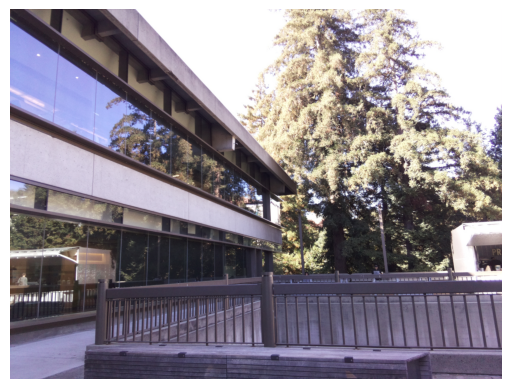
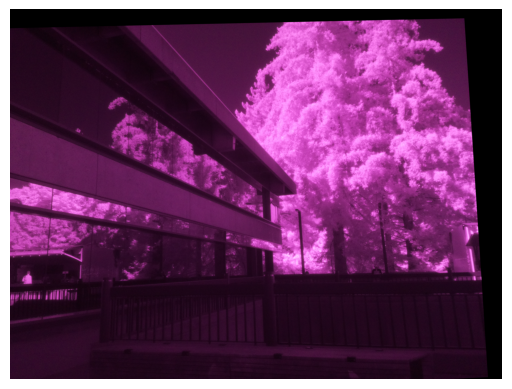

In [13]:
%%compare

fig, ax1 = plt.subplots()
ax1.axis("off")
ax1.imshow(cv2.cvtColor(im_vis, cv2.COLOR_BGR2RGB))

# Align and covert the 
fig, ax2 = plt.subplots()
ax2.axis("off")
im_aligned = align_images(im_ir, im_vis, 2000, 0.1)
ax2.imshow(cv2.cvtColor(im_aligned, cv2.COLOR_BGR2RGB))